# Required to Run

## Pip installs

In [6]:
!pip install scattertext
!pip install wordcloud
!pip install networkx
!pip install textblob
!pip install spacy
!pip install nltk
!pip install sklearn
!pip install pyvis
!pip install networkx

## Import Libraries and Download Needed Packages


In [10]:
import re 
import ast
import os
from random import sample
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from typing import Tuple,List,Dict
import matplotlib.patches as mpatches
from ast import literal_eval


from numpy import load
import ast
from pyvis.network import Network
import networkx as nx

import sklearn
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

import wordcloud
from wordcloud import WordCloud, STOPWORDS
import scattertext as st
import networkx

from textblob import TextBlob
import spacy
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import sklearn
from sklearn import preprocessing

In [11]:
nltk.download('vader_lexicon')
pd.set_option('display.max_colwidth', 0)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Read Data
Get twitter data and pre-labeled sentiment data for each tweet. Merge the two to get a sentiment and a color for each tweet of the dataset

In [109]:

root = "./drive/MyDrive/OFFICE/School/ISYE6748/"
twitterRoot = os.path.join(root,"data/twitter-data")
pathToData = os.path.join(twitterRoot,"twitter_large_dataset.csv")

cleanMediumDataPath = os.path.join(twitterRoot,"clean-data/clean_twitter_medium_dataset.csv")
cleanFullDataPath = os.path.join(twitterRoot,"clean-data/clean_twitter_large_dataset.txt")

labeledFullDataPath = os.path.join(twitterRoot,"labeled-data")

labeledFilePath = os.path.join(labeledFullDataPath,"twitter-large-dataset-labeled-cnn-1-model-2-dropout.csv")

df = pd.read_csv(pathToData, index_col= 0, encoding="utf-8")
df = df.astype({"id":pd.Int64Dtype(),"reply_to_id":pd.Int64Dtype()})

dfLabeled = pd.read_csv(labeledFilePath, index_col= None, encoding="utf-8")[["id","sentiment","color"]]
dfLabeled = dfLabeled.astype({"id":pd.Int64Dtype()})

In [110]:
dfLabeled

,id,sentiment,color
0,999724034811019264,anger,"(0.667, 0.333, 1.0, 0.531)"
1,999011491780202497,joy,"(0.333, 0.667, 1.0, 0.971)"
2,999010354473656321,joy,"(0.333, 0.667, 1.0, 0.977)"
3,999008238988414977,joy,"(0.333, 0.667, 1.0, 0.796)"
4,999005954099372032,joy,"(0.333, 0.667, 1.0, 0.951)"
...,...,...,...
157779,1003410245740257281,sadness,"(0.502, 0.498, 1.0, 0.999)"
157780,1001918237905387520,joy,"(0.333, 0.667, 1.0, 0.41)"
157781,1000930831823724545,sadness,"(0.502, 0.498, 1.0, 0.999)"
157782,1000875558211731456,joy,"(0.333, 0.667, 1.0, 0.653)"


In [111]:
df = df.merge(dfLabeled, on = "id", how = "left")

In [112]:
df.head(1)

,created_at,id,reply_to_id,screen_name,coordinates,place,retweet_count,favorite_count,lang,source,is_quote_status,user_id,user_loc,user_description,verified,followers_count,friends_count,favourites_count,statuses_count,listed_count,user_created_at,text,sentiment,color
0,2018-05-24 18:49:18,999724034811019264,992835709407973376,ifindkarma,NaN,NaN,1169,2572,en,Twitter for iPad,True,1688,"Silicon Valley, California ✨","b'Manhattan, PLEASE VOTE @ElizaOrlins @MayaWiley. And thank you @StaceyAbrams, @MarcEElias, and @HarrisonJaime for fighting for our VOTING RIGHTS. #Grateful \xf0\x9f\x8f\xb4\xe2\x80\x8d\xe2\x98\xa0\xef\xb8\x8f'",True,214495,115736,301837,88233,893,2006-07-17 01:21:51,"b'Remember the words of Mahatma Gandhi:\n\n\xe2\x80\x9cRemember that all through history, there have been tyrants and murderers, and for a time, they seem invincible. But in the end, they always fall. Always.\xe2\x80\x9d\n\nWhen we need hope, also remember the words of Alyssa Milano: https://t.co/uvOrN85o7U'",anger,"(0.667, 0.333, 1.0, 0.531)"


In [113]:
df.groupby("reply_to_id")["id"].count().sort_values()

reply_to_id
681025943926865920     1 
1396863879800569856    1 
1396863934104317952    1 
1396865243788218368    1 
1396866909098979328    1 
                      .. 
1393985851022008320    55
1401902338806358016    59
1394269468889690112    62
1400539651044167680    68
1402694705855401984    81
Name: id, Length: 42072, dtype: int64

# Review the spread of sentiment overall in the dataset

In [114]:
dfSubSet = df[["text", "user_description", "id","user_id","sentiment","color"]]
dfSubSet = dfSubSet.dropna()
dfSubSet.head(2)

,text,user_description,id,user_id,sentiment,color
0,"b'Remember the words of Mahatma Gandhi:\n\n\xe2\x80\x9cRemember that all through history, there have been tyrants and murderers, and for a time, they seem invincible. But in the end, they always fall. Always.\xe2\x80\x9d\n\nWhen we need hope, also remember the words of Alyssa Milano: https://t.co/uvOrN85o7U'","b'Manhattan, PLEASE VOTE @ElizaOrlins @MayaWiley. And thank you @StaceyAbrams, @MarcEElias, and @HarrisonJaime for fighting for our VOTING RIGHTS. #Grateful \xf0\x9f\x8f\xb4\xe2\x80\x8d\xe2\x98\xa0\xef\xb8\x8f'",999724034811019264,1688,anger,"(0.667, 0.333, 1.0, 0.531)"
1,"b'In Rhode Island and across the country, our water infrastructure needs significant investments to keep up with current demand and prepare for climate change. That\xe2\x80\x99s why I\xe2\x80\x99m proud this legislation includes a bill I cosponsored that would help finance water needs.'","b'U.S. Senator from Rhode Island, the Ocean State.'",999011491780202497,242555999,joy,"(0.333, 0.667, 1.0, 0.971)"


,sentiment,count
2,joy,78051
4,sadness,52035
0,anger,10362
1,fear,8675
3,love,4838
5,surprise,3823


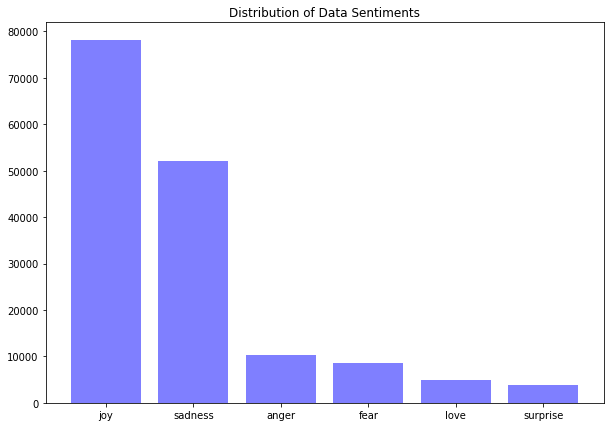

In [115]:
def plotSentimentFreq(df):
  aggDf = df.groupby("sentiment").size().reset_index(name='count').sort_values(by = "count", ascending = False)
  fig, ax = plt.subplots(1,1,figsize=(10, 7))
  ax.bar(aggDf["sentiment"],aggDf["count"], color = "blue", alpha = 0.5)
  ax.set_title("Distribution of Data Sentiments")
  fig.show()
  return aggDf

plotSentimentFreq(dfSubSet)

In [116]:
# Code to parse out the metntions and the hashtags from text and user description

def getTwitterMentions(text:str)->List[str]:
    """
    twitter mentions are prefixed with an @
    """
    word:str = re.findall(r'(?<=@)\w+',text)
    return " ".join(word)

def getTwitterHashtags(text:str)->List[str]:
    """
    twitter hashtags are prefixed with an #
    """
    word:str = re.findall(r'#(\w+)',text)
    return " ".join(word)


# Hastags Review 
<hr>


extract hashtags and mentions from the text of the tweet

In [117]:
dfSubSet["hashtags"] = dfSubSet['text'].apply(getTwitterHashtags)
dfSubSet["mentions"] = dfSubSet['text'].apply(getTwitterMentions)
dfSubSet.head(4)

,text,user_description,id,user_id,sentiment,color,hashtags,mentions
0,"b'Remember the words of Mahatma Gandhi:\n\n\xe2\x80\x9cRemember that all through history, there have been tyrants and murderers, and for a time, they seem invincible. But in the end, they always fall. Always.\xe2\x80\x9d\n\nWhen we need hope, also remember the words of Alyssa Milano: https://t.co/uvOrN85o7U'","b'Manhattan, PLEASE VOTE @ElizaOrlins @MayaWiley. And thank you @StaceyAbrams, @MarcEElias, and @HarrisonJaime for fighting for our VOTING RIGHTS. #Grateful \xf0\x9f\x8f\xb4\xe2\x80\x8d\xe2\x98\xa0\xef\xb8\x8f'",999724034811019264,1688,anger,"(0.667, 0.333, 1.0, 0.531)",,
1,"b'In Rhode Island and across the country, our water infrastructure needs significant investments to keep up with current demand and prepare for climate change. That\xe2\x80\x99s why I\xe2\x80\x99m proud this legislation includes a bill I cosponsored that would help finance water needs.'","b'U.S. Senator from Rhode Island, the Ocean State.'",999011491780202497,242555999,joy,"(0.333, 0.667, 1.0, 0.971)",,
2,"b'I\xe2\x80\x99m also proud that the America\xe2\x80\x99s Water Infrastructure Act of 2018 includes my provision that requires the Army Corps to report on its research and make recommendations on expanded use of composites, such as those made by RI manufacturers, and other innovative materials.'","b'U.S. Senator from Rhode Island, the Ocean State.'",999010354473656321,242555999,joy,"(0.333, 0.667, 1.0, 0.977)",,
3,"b'The America\xe2\x80\x99s Water Infrastructure Act of 2018 will direct the Army Corps of Engineers to complete ongoing projects in RI, including those that address coastal flooding risks and navigation in the Providence River. Read more here: https://t.co/RFKnyzbwuP'","b'U.S. Senator from Rhode Island, the Ocean State.'",999008238988414977,242555999,joy,"(0.333, 0.667, 1.0, 0.796)",,


For this review, drop rows with tweets that don't have any mentions or hashtags. 

Split the string into a list of hashtags/mentions

In [118]:
dfSubSet = dfSubSet.where(dfSubSet["hashtags"] != "").dropna()
dfSubSet = dfSubSet.where(dfSubSet["mentions"] != "").dropna()
dfSubSet["hashtags"] = dfSubSet["hashtags"].apply(lambda row: row.split(" ")) 
dfSubSet["mentions"] = dfSubSet["mentions"].apply(lambda row: row.split(" "))

Review results

Get the hashtag data into a separate table to perform futher analysis with it. 

Steps:
1. Transform/explode the hashtag / mentions column with lists into a column with each row being a single hashtag / mentions. 
2. Aggregate mentions and hashtags and get average sentimental score for the particular hashtag
3. Review hashtags and mentions and their scores with colors

In [120]:
sentimentColorMap  = {
    'anger': (1,0.498039215686275,0,1),
    'fear': (0.894117647058824, 0.101960784313725, 0.109803921568627, 1.0),
    'joy': (0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0),
    'love': (0.301960784313725, 0.686274509803922, 0.290196078431373, 1.0),
    'sadness': (0.596078431372549, 0.305882352941176, 0.63921568627451, 1.0),
    'surprise': (0.890196078431372,0.101960784313725,0.109803921568627,1)
    }

In [121]:
def countSentimentOccurence(group:pd.Series,sentiment:str):
  return len(group[group==sentiment])

def assignColor(row,colorMap):
  color = list(colorMap[row[0]])
  print(color)
  #color[3] = row[1]
  #finalCol = matplotlib.colors.to_hex(tuple(color), keep_alpha=True)
  return color

def getSingleSentiment(row:pd.Series, getCol:str):
  sentimentData = row[["anger","fear","joy","love","sadness","surprise"]]
  sentiment = sentimentData.astype(float).idxmax()
  weight = row[sentiment]/row["count"]
  return sentiment, weight 

def getGroupedStats(df:pd.DataFrame, get_column: str)->pd.DataFrame:

  scoresDf = df[[get_column,"sentiment"]].explode(get_column).copy(deep = True)
  
  scoresDfAgg = scoresDf.groupby([get_column])\
    .agg(
        count = (get_column,"count"),
        anger = ("sentiment",lambda group: countSentimentOccurence(group,"anger")),
        fear = ("sentiment",lambda group: countSentimentOccurence(group,"fear")),
        joy = ("sentiment",lambda group: countSentimentOccurence(group,"joy")),
        love = ("sentiment",lambda group: countSentimentOccurence(group,"love")),
        sadness = ("sentiment",lambda group: countSentimentOccurence(group,"sadness")),
        surprise = ("sentiment",lambda group: countSentimentOccurence(group,"surprise"))         
         ).reset_index()
  scoresDfAgg[["sentiment","weight"]] = scoresDfAgg.apply(getSingleSentiment, args = ("hashtags",), axis = 1, result_type="expand")
  scoresDfAgg["weight"] = (scoresDfAgg["weight"]- scoresDfAgg["weight"].min())/\
                           (scoresDfAgg["weight"].max() - scoresDfAgg["weight"].min())
  scoresDfAgg["color"] = scoresDfAgg[["sentiment","weight"]].apply(lambda row: assignColor(row,sentimentColorMap), axis = 1) 
  scoresDfAgg.sort_values("count", ascending=False, inplace = True)
  return scoresDfAgg


def getTop50Handles(df:pd.DataFrame)->pd.DataFrame: 
  top50Hashtags = df.sort_values(by = "count", ascending = False).head(50).copy(deep = True)
  return top50Hashtags

def plotTop50(df:pd.DataFrame, plotColName:str)->None:
  w = 10
  h = 14
  maxIndx = df["count"].max()

  plt.figure(figsize=(w,h))

  plt.barh(df[plotColName],df["count"], color = df["color"])
  plt.yticks(fontsize=12)

  handles = [mpatches.Patch(color=sentimentColorMap[key], label= key) for key in sentimentColorMap]
  
  labels = list(sentimentColorMap.keys())
  handles = [plt.Rectangle((0,0),1,1, color=sentimentColorMap[key]) for key in sentimentColorMap]

  plt.legend(handles, labels, prop={'size': 15})
  text = "color saturation is \n indicative of \n sentiment certainty"
  text_kwargs = dict(fontsize=12, color='black')
  plt.text(maxIndx/2, 45, text, **text_kwargs)
  
  plt.title(f"Sentiment Map around top 50 {plotColName} and their frequency")
  plt.show()

Streaming output truncated to the last 5000 lines.
[0.301960784313725, 0.686274509803922, 0.290196078431373, 1.0]
[0.596078431372549, 0.305882352941176, 0.63921568627451, 1.0]
[0.894117647058824, 0.101960784313725, 0.109803921568627, 1.0]
[0.596078431372549, 0.305882352941176, 0.63921568627451, 1.0]
[0.596078431372549, 0.305882352941176, 0.63921568627451, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.301960784313725, 0.686274509803922, 0.290196078431373, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.596078431372549, 0.305882352941176, 0.63921568627451, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[1, 0.498039215686275, 0, 1]
[1, 0.498039215686275, 0, 1]
[0.596078431372549, 

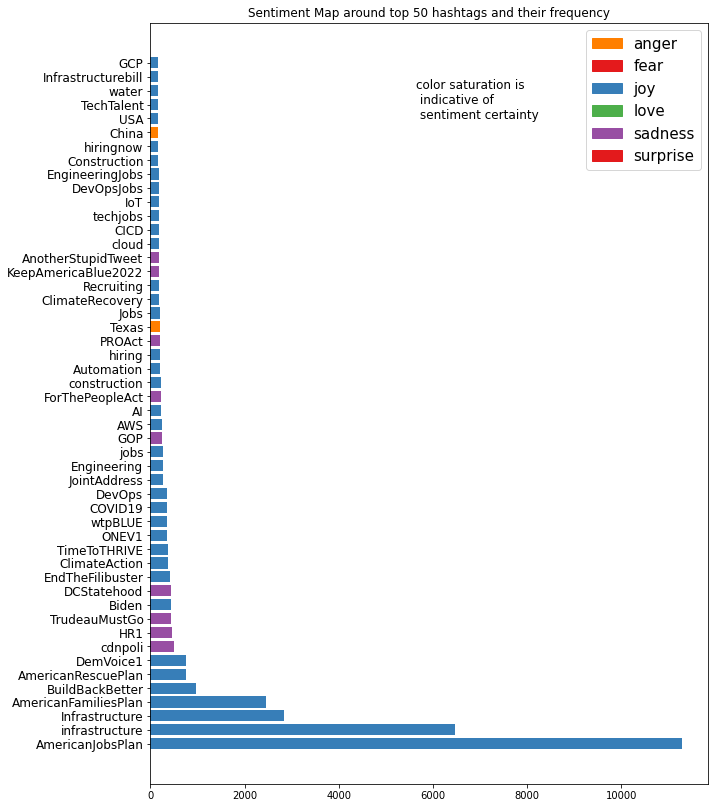

In [122]:
hashtagAggDf = getGroupedStats(dfSubSet, get_column= 'hashtags')
top50Hashtags = hashtagAggDf.head(50).copy(deep = True)
plotTop50(top50Hashtags, "hashtags")

Streaming output truncated to the last 5000 lines.
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.596078431372549, 0.305882352941176, 0.63921568627451, 1.0]
[0.894117647058824, 0.101960784313725, 0.109803921568627, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]
[0.894117647058824

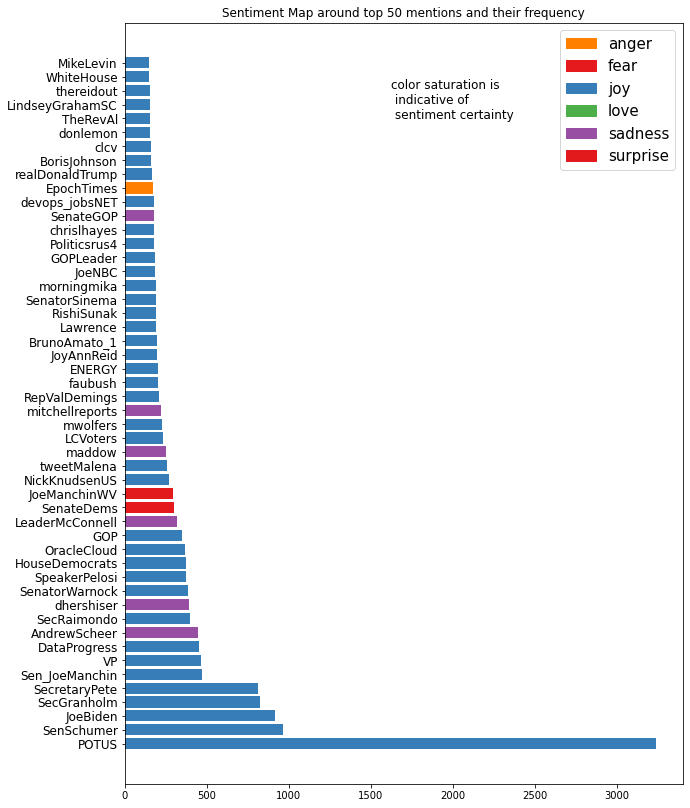

In [123]:
mentionsAggDf = getGroupedStats(dfSubSet, get_column= 'mentions')
top50Mentions = mentionsAggDf.head(50).copy(deep = True)
plotTop50(top50Mentions, "mentions")

# Word Cloud Reiview
<hr>

Use a wordcloud image to review mentions and hashtags from another perspective

In [124]:
def sentiment_colors_hashtag(word, font_size, position, orientation, random_state=None,
                    **kwargs):
  
  color = hashtagAggDf[hashtagAggDf["hashtags"]==word].color.values

  return get_colors(color)

def sentiment_colors_mention(word, font_size, position, orientation, random_state=None,
                    **kwargs):
  color = mentionsAggDf[mentionsAggDf["mentions"]==word].color.values

  return get_colors(color)

def get_colors(color):
  # takes a tupe of color weights (1,0.5,0.2,1) -> str 
  colors = [int(100*c) for c in color[0]][0:3]
  return  "rgb(%d%%,%d%%,%d%%)"%tuple(colors)

def wordCloudListReview(df,title, column_name = "hashtags"):
  #listOfWords = df[column_name]
  # instantiate a word cloud object
  wcObj = WordCloud(
      collocations=False,
      width=800, height=400,
      background_color='white',
      max_words=2000,
      mode = "RGBA"
      )
  # generate the word cloud
  freq_data = dict(zip(df[column_name], df["count"]))
  wcObj.generate_from_frequencies(freq_data)#.generate(" ".join(listOfWords))


  fig = plt.figure()
  fig.set_figwidth(20) # set width
  fig.set_figheight(20) # set height
  # display the cloud
  plt.imshow(wcObj, interpolation='bilinear')

  if column_name == "hashtags":
    plt.imshow(wcObj.recolor(color_func=sentiment_colors_hashtag, random_state=3),
            interpolation="bilinear")
  else: 
    plt.imshow(wcObj.recolor(color_func=sentiment_colors_mention, random_state=3),
        interpolation="bilinear")
    
  plt.axis('on')
  plt.tick_params(bottom = False, \
                  left=False, \
                  which='both', \
                  labelbottom=False,
                  labelleft=False)
  handles = [mpatches.Patch(color=sentimentColorMap[key], label= key) for key in sentimentColorMap]
  
  labels = list(sentimentColorMap.keys())
  handles = [plt.Rectangle((0,0),1,1, color=sentimentColorMap[key]) for key in sentimentColorMap]

  plt.legend(handles, labels, prop={'size': 15})
  plt.title(title)
  plt.show()

In [125]:
hashtagAggDf.head()

,hashtags,count,anger,fear,joy,love,sadness,surprise,sentiment,weight,color
435,AmericanJobsPlan,11287,171,766,7643,248,2369,90,joy,0.569534,"[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]"
8489,infrastructure,6473,293,477,3356,192,2078,77,joy,0.357948,"[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]"
3264,Infrastructure,2847,271,199,1709,75,559,34,joy,0.467041,"[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]"
428,AmericanFamiliesPlan,2446,43,186,1676,90,450,1,joy,0.580267,"[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]"
915,BuildBackBetter,964,4,62,762,12,123,1,joy,0.720609,"[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]"


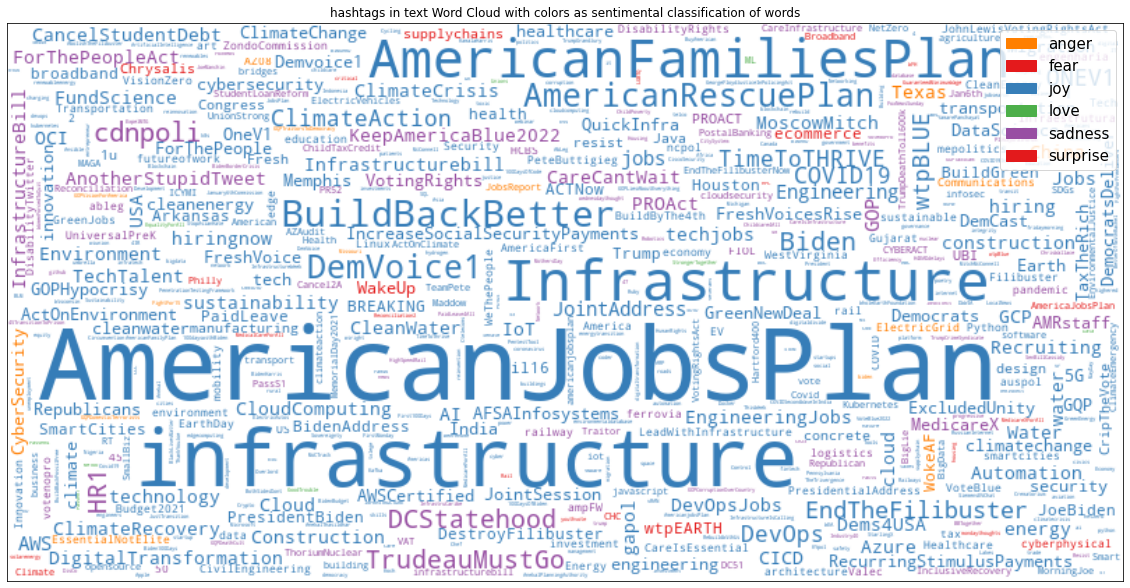

In [126]:
title = "hashtags in text Word Cloud with colors as sentimental classification of words"
wordCloudListReview(hashtagAggDf, title = title)

In [127]:
mentionsAggDf.head(4)

,mentions,count,anger,fear,joy,love,sadness,surprise,sentiment,weight,color
4898,POTUS,3242,81,300,1922,85,836,18,joy,0.476514,"[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]"
6131,SenSchumer,963,22,11,611,18,299,2,joy,0.530040,"[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]"
3336,JoeBiden,916,45,49,442,14,352,14,joy,0.334685,"[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]"
6057,SecGranholm,822,1,18,677,20,106,0,joy,0.773201,"[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]"


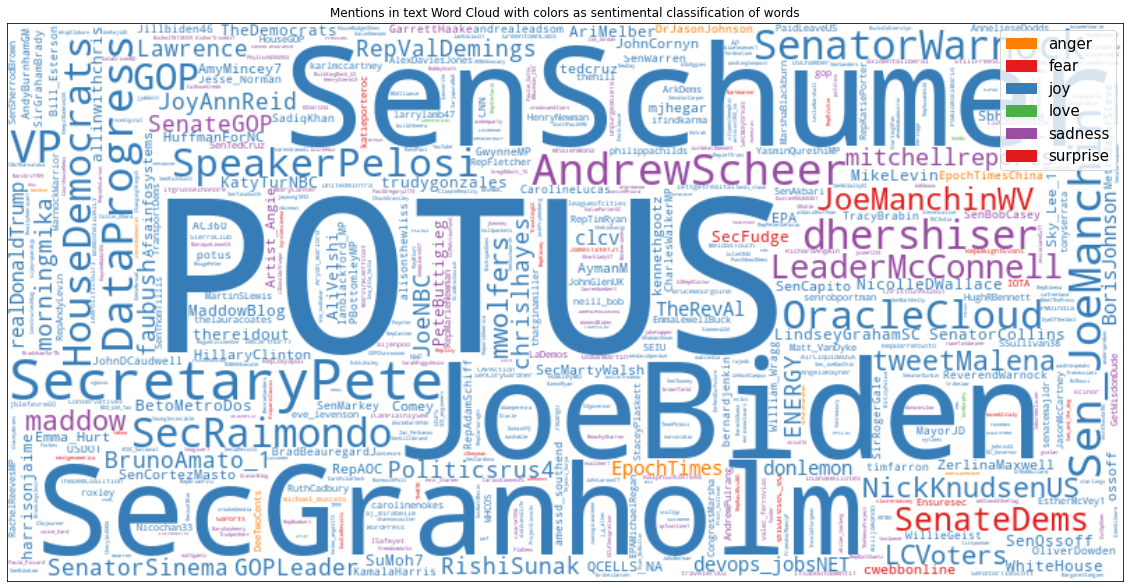

In [128]:
title = "Mentions in text Word Cloud with colors as sentimental classification of words"
wordCloudListReview(mentionsAggDf, title = title, column_name="mentions")

# Build Relational Graph
<hr>
Review the network connections between mentions: 

1. Create a graph with the following attributs: 
  a. if two mentions are in one tweet, then they have a connection or an edge 
  b. Node size = frequency used 
  c. Node color = sentiment 
  d. Edge color/weight = number of times two mentions are in one tweet

2. Save Edges and Nodes, build graph to visualize

In [129]:
distrinctHandles = mentionsAggDf[["mentions","sentiment","weight","color"]].copy(deep = True).reset_index(drop=True)

In [130]:
distrinctHandles.head(3)

,mentions,sentiment,weight,color
0,POTUS,joy,0.476514,"[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]"
1,SenSchumer,joy,0.530040,"[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]"
2,JoeBiden,joy,0.334685,"[0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0]"


## Build a relational matrix
Reduce the matrix to only include the upper triangle so as to not have repeated edges


In [131]:
maxIndex = int(distrinctHandles.index.stop)
mentionMatrix = np.zeros((maxIndex, maxIndex))

In [132]:
for tweet in dfSubSet.mentions.values:
  for itemA in tweet:
    i = distrinctHandles[distrinctHandles.mentions == itemA].index[0]
    for itemB in tweet:
      j = distrinctHandles[distrinctHandles.mentions == itemB].index[0]
      mentionMatrix[i][j] = mentionMatrix[i][j]+1

In [133]:
mentionMatrixTriag = np.triu(mentionMatrix, 1) 
mentionMatrixTriag

array([[  0., 255., 215., ...,   0.,   0.,   0.],
       [  0.,   0., 139., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

### Generate a Relational Matrix 
<hr>

Generate Dataframe with Nodes and Edges and save to CSV. 
Build the weights, nodeA (destination) nodeB (source) lists, drop them into a pandas dataframe and save as a csv

In [134]:
m,n = mentionMatrixTriag.shape
weights = []
nodeAlist = []
nodeBlist = []
for row_val in range(m):
  for col_val in range(n):
    weight = mentionMatrixTriag[row_val][col_val]
    if weight > 0: 
      node_nameA = distrinctHandles.loc[row_val,"mentions"]
      node_nameB = distrinctHandles.loc[col_val,"mentions"]
      weights.append(weight)
      nodeAlist.append(node_nameA)
      nodeBlist.append(node_nameB)

#### Normalize weights and save

In [135]:
edgesPath = "./drive/MyDrive/OFFICE/School/ISYE6748/data/edges_full_cnn.csv"
distrinctHandlesPath = "./drive/MyDrive/OFFICE/School/ISYE6748/data/distinc_handles_full_cnn.csv"

Normalize weights

In [136]:
dfedges = pd.DataFrame({"edgeA":nodeAlist, "edgeB":nodeBlist, "weights": weights})
dfedges["weights_norm"] = preprocessing.MinMaxScaler()\
    .fit_transform(np.array(dfedges["weights"]).reshape(-1,1)).round(3)

In [137]:
dfedges.to_csv(edgesPath,header=True, index = False)
distrinctHandles.to_csv(distrinctHandlesPath,header=True,index=False)

### Generate nods and save
Read saved edes from path. This is handy to come back to later and just read from the path rather than rerunning the whole notebook. 

In [138]:
dfedges = pd.read_csv(edgesPath)
distrinctHandles = pd.read_csv(distrinctHandlesPath)

In [139]:
dfedges.head()

,edgeA,edgeB,weights,weights_norm
0,POTUS,SenSchumer,255.0,0.686
1,POTUS,JoeBiden,215.0,0.578
2,POTUS,SecGranholm,61.0,0.162
3,POTUS,SecretaryPete,86.0,0.230
4,POTUS,Sen_JoeManchin,75.0,0.200


### Get the unique set of mentions

In [140]:
def getNodeFreqData(df):
  nodesDf = df[["edgeA"]].rename(columns = {"edgeA":"nodes"})
  nodesDf = nodesDf.append(df[["edgeB"]].rename(columns = {"edgeB":"nodes" }))
  countsDf =  nodesDf.groupby(["nodes"]).size().reset_index(name = "counts")
  countsDf["counts"] = preprocessing.MinMaxScaler()\
    .fit_transform(np.array(countsDf["counts"]).reshape(-1,1)).round(3)
  countsDf = countsDf.sort_values(by = "counts", ascending=False)
  return countsDf

In [141]:
nodes = getNodeFreqData(dfedges)
nodes

,nodes,counts
3867,POTUS,1.000
2647,JoeBiden,0.424
5604,VP,0.406
1965,GOP,0.275
4836,SenSchumer,0.256
...,...,...
2210,HabitatNYC,0.000
6291,cayimby,0.000
6293,cbs4rgv,0.000
6295,cbuilde,0.000


In [142]:
node_colors = []
node_sizes = []
node_names = []
for index, row in nodes.iterrows():
  node = row["nodes"]
  if len(distrinctHandles[distrinctHandles.mentions == node])>0:
    node_names.append(node)
    colorList = ast.literal_eval(distrinctHandles[distrinctHandles.mentions == node].reset_index().loc[0,"color"])
    node_colors.append(tuple(colorList))
    node_sizes.append(row["counts"])

In [143]:
len(node_names)

8658

### Save Nodes Data


In [144]:
nodesPath = "./drive/MyDrive/OFFICE/School/ISYE6748/data/nodes_full_cnn.csv"
dfNodes = pd.DataFrame({"nodes":node_names, "sizes":node_sizes, "colors": node_colors})

In [145]:
dfNodes.loc[0,"colors"]

(0.215686274509804, 0.494117647058824, 0.72156862745098, 1.0)

In [146]:
dfNodes.to_csv(nodesPath,header=True, index = False)

# Generate the relational graph from saved nodes and edges. 
There are many options for this step, some python native, and many external tools. I went with pyvis netwrok for quick a quick visualization


In [147]:
nodesPath = "./drive/MyDrive/OFFICE/School/ISYE6748/data/nodes_full_cnn.csv"
edgesPath = "./drive/MyDrive/OFFICE/School/ISYE6748/data/edges_full_cnn.csv"

dfedges = pd.read_csv(edgesPath)
dfNodes = pd.read_csv(nodesPath)
dfNodes["colors"] = dfNodes["colors"].apply(lambda x: matplotlib.colors.to_hex(literal_eval(x), keep_alpha=True))
dfNodes.head()

,nodes,sizes,colors
0,POTUS,1.000,#377eb8ff
1,JoeBiden,0.424,#377eb8ff
2,VP,0.406,#377eb8ff
3,GOP,0.275,#377eb8ff
4,SenSchumer,0.256,#377eb8ff


In [152]:
dfedges

,edgeA,edgeB,weights,weights_norm
0,POTUS,SenSchumer,255.0,0.686
1,POTUS,JoeBiden,215.0,0.578
2,POTUS,SecGranholm,61.0,0.162
3,POTUS,SecretaryPete,86.0,0.230
4,POTUS,Sen_JoeManchin,75.0,0.200
...,...,...,...,...
47738,NYCMayorsOffice,NYCCouncil,1.0,0.000
47739,NRTConnect,NRECA,1.0,0.000
47740,OrstedUS,OffshoreWindCA,1.0,0.000
47741,PASenateGOP,PAGOP,1.0,0.000


In [153]:
def getTopData(df,dfedges,topNr):
  countsDf = getNodeFreqData(dfedges).head(topNr)
  topDf = countsDf.merge(df, on = "nodes", how = "left")
  return topDf


def getTopEdges(dfNodes):
  nodeList = dfNodes.nodes.to_list()
  df = dfedges[(dfedges.loc[:,"edgeA"].isin(nodeList))&(dfedges.loc[:,"edgeB"].isin(nodeList))]
  return df



In [154]:
dfNodesReduced = getTopData(dfNodes,dfedges,20)
dfNodesReduced
dfEdgesReduced = getTopEdges(dfNodesReduced)
dfEdgesReduced

,edgeA,edgeB,weights,weights_norm
0,POTUS,SenSchumer,255.0,0.686
1,POTUS,JoeBiden,215.0,0.578
3,POTUS,SecretaryPete,86.0,0.230
4,POTUS,Sen_JoeManchin,75.0,0.200
5,POTUS,VP,281.0,0.757
...,...,...,...,...
16449,kcinor,RalphS24381648,46.0,0.122
16451,kcinor,OxmanMartin,46.0,0.122
16638,ICanPlainlySee,RalphS24381648,46.0,0.122
16640,ICanPlainlySee,OxmanMartin,46.0,0.122


In [156]:
g = Network(height=500,width=500, notebook=True)
g.toggle_hide_edges_on_drag(True)
g.barnes_hut()

In [157]:
#Generate nodes
for index,row in dfNodesReduced.iterrows():
  node = row["nodes"]
  color = row["colors"]
  size = row["sizes"]
  g.add_node(node, color = color, label =node, size = 100*size, label_size = 100, node_shape = "o") 

In [158]:
#generate edges
for index,row in dfEdgesReduced.iterrows():
  source = row["edgeA"]
  target = row["edgeB"]
  g.add_edge(source, target) 

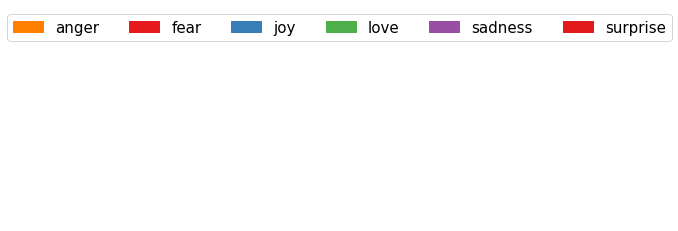

In [159]:
g.show_buttons(filter_=['physics'])

sentimentColorMap

from IPython.core.display import display, HTML
labels = list(sentimentColorMap.keys())
handles = [plt.Rectangle((0,0),1,1, color=sentimentColorMap[key]) for key in sentimentColorMap]
plt.legend(handles, labels, prop={'size': 15},loc="upper center", ncol=len(labels))
plt.axis('off')
g.show('network.html')
display(HTML('network.html'))